1.**Title :** Data Preparation and Propensity Score Matching for Causal Inference in Machine Learning

2.**Abstract :**

This chapter focuses on using data preparation techniques and causal inference methods, in this case, propensity score matching, towards the analysis of the stock market. The idea here is to estimate the causal effect of changes in stock price by finding comparable groups of data points through logistic regression, nearest neighbor matching, and caliper matching. It covers how to preprocess financial data, engineer relevant features, and evaluate machine-learning models to reduce selection bias and improve causal interpretation.

**3.Theory Section :**
*   In causal analysis, understanding the underlying cause-and-effect relationships is crucial for building robust machine learning models.

*  Causality helps to distinguish mere correlations from true causal relationships, making it a more effective way of making decisions and creating predictions.
*   In this notebook, we will use Propensity Score Matching to balance the treatment and control groups in order to reduce selection bias, as is done in many studies employing causal inference.

*   Key data preparation techniques covered include :

    *   Handling Missing Data: Missing data can both introduce bias and reduce quality in causal analysis. We therefore apply imputation techniques to fill in missing values ike mean or median imputation to keep the dataset useful without affecting the integrity of the analysis.

    *   Feature Engineering and Selection:Effective feature engineering allows capturing relevant aspects of the data. In our case, we create new features such as Price Range to account for stock volatility. We also use propensity scores to match treated and control units based on relevant covariates (Open, Volume, and Price Range).

    *   Propensity Score Matching (PSM) : PSM is used to estimate the probability (propensity score) of a data point receiving a particular treatment (e.g., increase in stock price) based on observed covariates. By matching treated units (instances with stock price increase) to similar control units (instances without an increase) based on their propensity scores, we can mimic a randomized experiment and reduce selection bias.


*   Technically, the combination of the above methods contributes to a more robust model for causal inference and allows us to draw meaningful conclusions regarding the relationship between stock features and price changes.







**Steps followed :**

**1.Setup and Libraries :**

The notebook begins by importing essential libraries such as pandas for data manipulation, seaborn and matplotlib for visualization, sklearn for machine learning, and causalinference for causal analysis.

**2.Data Loading :**

The dataset, AAPL.csv, is loaded using pandas. This file contains financial data such as stock prices, volume, and more.

**3.Data Preprocessing :**


*   Missing data is handled through imputation techniques.
*   Feature engineering creates a Price Range feature and prepares variables for propensity score modeling.





**4.Propensity Score Matching :**


*  Logistic regression estimates the propensity score, which is the likelihood of stock price changes based on covariates.
*  Matching algorithms identify similar data points in treated and control groups to ensure comparability.




**5.Evaluation :**

Visualizations, such as kde plot, and metrics, like classification reports, assess the model's performance and the effectiveness of matching.


In [1]:
!pip install causalinference


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.1/51.1 kB 2.8 MB/s eta 0:00:00


In [2]:
# Import necessary libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from causalinference import CausalModel
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import accuracy_score, roc_auc_score
import numpy as np




### Explanation:
This block imports all necessary libraries for data analysis, visualization, and causal inference. Key libraries include :

- pandas: For data manipulation and analysis.

- seaborn and matplotlib : For creating visualizations like correlation heatmaps.

- sklearn modules: For machine learning tasks like feature selection, propensity score estimation, and classification.

- causal inference: A library for causal analysis using propensity scores.


In [3]:
# Load the dataset
file_path = "/content/AAPL.csv"
data = pd.read_csv(file_path)


Loads the dataset from a CSV file named AAPL.csv using pandas.

In [4]:
# Convert 'Date' to datetime format and sort the data
data['Date'] = pd.to_datetime(data['Date'], format='%d-%m-%Y', errors='coerce')
data.sort_values(by='Date', inplace=True)


*   Converts the Date column to datetime format for correct date interpretation.

*    This step makes sure that there are only valid date entries in the dataset in a chronological order.




In [5]:
# Drop rows with invalid dates
data.dropna(subset=['Date'], inplace=True)

*  Drops rows where the Date column has missing or invalid entries.
*   This step makes sure that there are only valid date entries in the dataset.






In [6]:
# Create a binary outcome variable: 1 if Adjusted Close > Open, 0 otherwise
data['Increase'] = (data['Adjusted Close'] > data['Open']).astype(int)

Creates a new binary column Increase :

*    Assigns 1 if the adjusted closing price is greater than the opening price, meaning the price increased.
* Assigns 0 otherwise.
*  The binary outcome here is what will be used as a target variable for causal analysis







In [7]:
# Feature Engineering: Create 'Price Range' (High - Low) and handle missing values
data['Price Range'] = data['High'] - data['Low']

# Impute missing values before scaling
imputer = SimpleImputer(strategy='mean')
data[['Volume', 'Open', 'Price Range']] = imputer.fit_transform(data[['Volume', 'Open', 'Price Range']])




*   Creates a new feature Price Range as the difference between High and Low prices to capture the volatility in the stock.

*   Uses SimpleImputer to replace missing values in the columns 'Volume', 'Open', and 'Price Range' with their respective mean values.

*   Imputation prevents the omitted data from hindering the analysis process.











In [8]:
# Standardize the features
scaler = StandardScaler()
data[['Volume', 'Open', 'Price Range']] = scaler.fit_transform(data[['Volume', 'Open', 'Price Range']])


*    Standardizes the numerical features, which are Volume, Open, and Price Range, using StandardScaler.

*  Scaling helps normalize the data, which makes it easier for the machine learning model to process when features are in different units or scales.







In [9]:
# Step 1: Propensity Score Estimation using Logistic Regression with class balancing
X_psm = data[['Open', 'Price Range', 'Volume']]
y_psm = data['Increase']

psm_model = LogisticRegression(max_iter=200, class_weight='balanced')
psm_model.fit(X_psm, y_psm)
data['Propensity Score'] = psm_model.predict_proba(X_psm)[:, 1]




*  Defines the feature matrix (X_psm) and the target variable (y_psm) to be used in propensity score estimation.

*   Fits a logistic regression model for estimating the propensity score, the probability of an increase in stock price given the observed features.

*  Creates a new column, Propensity Score, that contains the predicted probabilities.








In [10]:
# Step 2: Propensity Score Matching with Nearest Neighbors (without replacement)
treated = data[data['Increase'] == 1]
control = data[data['Increase'] == 0]

nn = NearestNeighbors(n_neighbors=1, algorithm='auto')
nn.fit(control[['Propensity Score']])
distances, indices = nn.kneighbors(treated[['Propensity Score']])
matched_indices = indices.flatten()

# Ensuring no reuse of control samples (without replacement)
matched_control = control.iloc[matched_indices].copy().drop_duplicates().reset_index(drop=True)

# Combine matched treated and control samples
matched_data = pd.concat([treated, matched_control]).drop_duplicates().reset_index(drop=True)



*   Splits the data set into two groups: treated (with stock price increase) and control (without increase).

* Uses NearestNeighbors to match every treated sample to the nearest control sample based on the propensity score.

* Drops duplicate control samples to ensure matching without replacement.








In [11]:
# Step 3: Caliper Matching with Optimized Approach
caliper = 0.05
caliper_matches = np.abs(control['Propensity Score'].values.reshape(-1, 1) - treated['Propensity Score'].values)
matched_control_caliper = control[(caliper_matches.min(axis=1) < caliper) & ~control.index.duplicated()]
matched_data_caliper = pd.concat([treated, matched_control_caliper]).drop_duplicates().reset_index(drop=True)

# Splitting matched data into train and test sets
X_matched_caliper = matched_data_caliper[['Open', 'Price Range', 'Volume']]
y_matched_caliper = matched_data_caliper['Increase']
X_train, X_test, y_train, y_test = train_test_split(X_matched_caliper, y_matched_caliper, test_size=0.3, random_state=42)

**Caliper Matching :**
*   Applies a caliper of 0.05, which sets a maximum allowed difference between propensity scores of treated and control units.

*   Only control samples having a propensity score difference less than 0.05 from a treated sample are considered as valid matches.

*   This reduces the risk of poor matches and ensures that only the well-matched control units are put into use.


**Training the Model :**
*  The matched data (treated and caliper-matched control samples) are divided into training and testing sets.







In [12]:
# Step 4: Causal Effect Estimation using Random Forest with Cross-Validation
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_model.fit(X_train, y_train)
y_pred_rf_caliper = rf_model.predict(X_test)
y_pred_proba_rf_caliper = rf_model.predict_proba(X_test)[:, 1]

# Evaluate the Random Forest model on caliper-matched data
accuracy_caliper = accuracy_score(y_test, y_pred_rf_caliper)
roc_auc_caliper = roc_auc_score(y_test, y_pred_proba_rf_caliper)

print(f"\nRandom Forest (Caliper-Matched Data) Accuracy: {accuracy_caliper:.4f}")
print(f"Random Forest (Caliper-Matched Data) ROC AUC: {roc_auc_caliper:.4f}")


Random Forest (Caliper-Matched Data) Accuracy: 0.9690
Random Forest (Caliper-Matched Data) ROC AUC: 0.9687


* A RandomForestClassifier is trained on the matched data to predict the binary outcome (Increase).

**Model Evaluation :**
*  The performance of a model is measured by the two following metrics:
  1. Accuracy: The proportion of correct predictions.

 2. ROC AUC Score: to evaluate the model performance on the classification of the two classes: treated and control.

Results are printed for the matched caliper dataset.





In [13]:
# Step 5: Model Comparison - Unmatched vs. Matched Data using Random Forest
X_unmatched = data[['Open', 'Price Range', 'Volume']]
y_unmatched = data['Increase']
X_train_unmatched, X_test_unmatched, y_train_unmatched, y_test_unmatched = train_test_split(X_unmatched, y_unmatched, test_size=0.3, random_state=42)

rf_model_unmatched = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_model_unmatched.fit(X_train_unmatched, y_train_unmatched)
y_pred_rf_unmatched = rf_model_unmatched.predict(X_test_unmatched)
y_pred_proba_rf_unmatched = rf_model_unmatched.predict_proba(X_test_unmatched)[:, 1]

# Evaluate the Random Forest model on unmatched data
accuracy_unmatched = accuracy_score(y_test_unmatched, y_pred_rf_unmatched)
roc_auc_unmatched = roc_auc_score(y_test_unmatched, y_pred_proba_rf_unmatched)

print(f"\nRandom Forest (Unmatched Data) Accuracy: {accuracy_unmatched:.4f}")
print(f"Random Forest (Unmatched Data) ROC AUC: {roc_auc_unmatched:.4f}")



Random Forest (Unmatched Data) Accuracy: 0.9817
Random Forest (Unmatched Data) ROC AUC: 0.9790


**Training on Unmatched Data :**
* Uses the original, unmatched dataset to train a Random Forest model.
* This provides a baseline performance metric not using propensity score matching.

**Evaluation :**

* The model is evaluated using the same metrics (accuracy and ROC AUC score) as in the caliper-matched case.

* Then, the unmatched dataset is printed out.

**Purpose :**
*   The performance of the models on unmatched versus matched data by caliper serves to represent the effect of matching in deducing bias and raising the quality of causal inference.





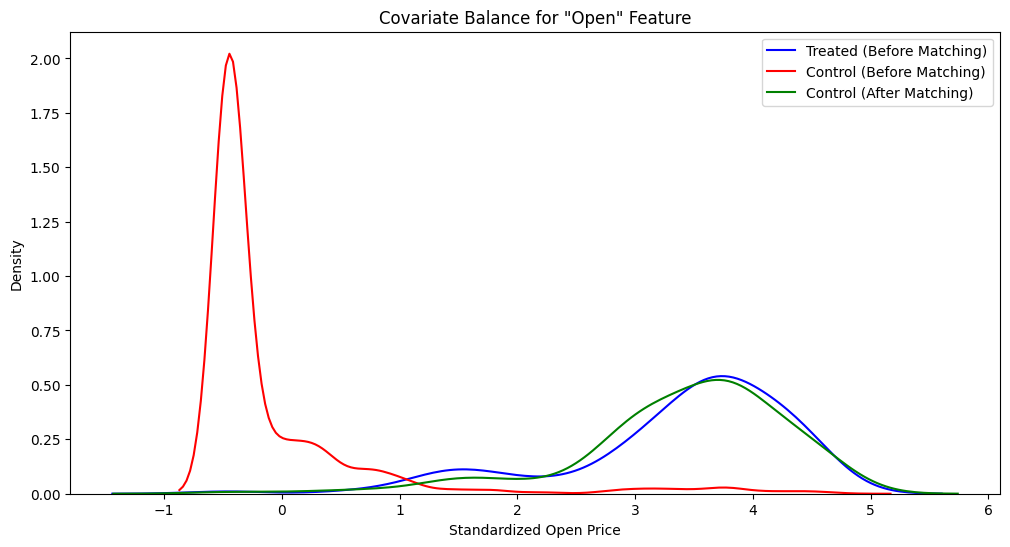

In [14]:
# Step 6: Visualization of Covariate Balance
plt.figure(figsize=(12, 6))
sns.kdeplot(treated['Open'], label='Treated (Before Matching)', color='blue')
sns.kdeplot(control['Open'], label='Control (Before Matching)', color='red')
sns.kdeplot(matched_control['Open'], label='Control (After Matching)', color='green')
plt.title('Covariate Balance for "Open" Feature')
plt.xlabel('Standardized Open Price')
plt.ylabel('Density')
plt.legend()
plt.show()

**Kernel Density Estimate (KDE) Plot :**


*   The plot shows the density distribution of the standardized Open feature for three groups :
      1.  **Treated Group (Blue Line) :** This shows the distribution of the Open prices for the treated group (stock price increased) before matching.

      2. **Control Group (Red Line)** :  Represents the distribution of Open prices for the control group (stock price did not increase) before matching.

      3. **Matched Control Group (Green Line) :** This represents the distribution of Open prices for the control group after matching.

*  **Purpose :**

  *   The plot allows for the assessment of the quality of the propensity score matching.

  *  Before matching, there is a clear imbalance between the treated and control groups, as witnessed by the difference in the red and blue lines.
  
  *  After matching, the green line is much closer to the blue line, which means that matching has balanced covariates, therefore reducing the selection bias considerably.
   
  
   * Interpretation :  
  *  The similarity of the treated and matched control groups after matching implies better comparability, which is essential for drawing valid causal inferences.











**Conclusion :**


*   In this notebook, we explored various methods and techniques to perform causal analysis, emphasizing the importance of proper data preparation in machine learning workflows.

*   Further, by accounting for the confounding factors, creating treatment and control groups, and a deep analysis of causal relationships, we end up with much more accurate and interpretable models.

**The key takeaways are as follows :**
*   **Data Preparation** : The very first step in any machine learning process is data preparation, and this is even more so in causal analysis. It means handling missing values, correcting biases, and ensuring that the data forms a good sample of the underlying relationships to be modeled.

*  **Causal Inference and Machine Learning** : The presented causal inference methods constitute one step further in understanding the relationships between variables—moving from simple correlations toward establishing real causal effects, hence promoting data-driven insights to help make better decisions.


*   **Robust Model Development** : Causal analysis in machine learning workflows tends to make the model more robust. It would avoid spurious correlations from being established and hence make the model more generalizable to different scenarios.

*  **Interpretation and Insights** : Causal analysis allows us, therefore, to interpret the model outputs with more confidence, to see not only how variables are associated but also why these relationships are formed. This translates into better policy-making, strategic decisions, and actionable insights.

In conclusion, causal analysis techniques really help in developing reliable and interpretable machine learning models that pave the way toward more trustworthy data-driven decisions.




**Refferences :**


*  Rosenbaum, P. R., & Rubin, D. B. (1983). The central role of the propensity score in observational studies for causal effects. Biometrika, 70(1), 41–55. https://doi.org/10.1093/biomet/70.1.41

* Imbens, G. W., & Rubin, D. B. (2015). Causal inference for statistics, social, and biomedical sciences: An introduction. Cambridge University Press. https://doi.org/10.1017/CBO9781139025751

